## Felles import for alle kodeblokker

In [ ]:
import sys
import calendar

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, Input, Output

sys.path.append("../analysis")

from basedata import DataLoader
from monthlystats import MonthlyStats
from yearlystats import YearlyStats
from outlieranalysis import OutlierAnalysis
from outlierdetector import OutlierDetector

loader = DataLoader("../../data/processed")
ms = MonthlyStats("../../data/processed")
ys = YearlyStats("../../data/processed")
oa = OutlierAnalysis("../../data/processed")
od = OutlierDetector()

## Tempratur forskjell by

In [9]:
# Hent ferdigberegnet temperaturspenn (range) for begge byer
df_oslo = ms.compute_all_months(
    "range(air_temperature P1D)",
    "oslo",
)
df_tromso = ms.compute_all_months(
    "range(air_temperature P1D)",
    "tromso",
)

# Legg til 'year', 'month' og 'temp_diff'
for df in (df_oslo, df_tromso):
    df["year_month"] = pd.to_datetime(df["year_month"])
    df["year"] = df["year_month"].dt.year
    df["month"] = df["year_month"].dt.month_name()
    df["temp_diff"] = df["mean"]  # Gi nytt navn for bruk i figuren

# Start Dash-app
app = Dash(__name__)

app.layout = html.Div(
    [
        html.H1("Temperature Range (Difference) per Month"),
        html.Label("City:"),
        dcc.Dropdown(
            id="city-dropdown",
            options=[
                {"label": "Oslo", "value": "Oslo"},
                {"label": "Tromsø", "value": "Tromsø"},
            ],
            value="Oslo",
        ),
        html.Label("Month:"),
        dcc.Dropdown(
            id="month-dropdown",
            options=[
                {"label": m, "value": m}
                for m in calendar.month_name[1:]
            ],
            value="January",
        ),
        html.Label("Start Year:"),
        dcc.Input(
            id="start-year",
            type="number",
            value=2000,
            min=2000,
            max=2023,
        ),
        html.Label("End Year:"),
        dcc.Input(
            id="end-year",
            type="number",
            value=2023,
            min=2000,
            max=2023,
        ),
        dcc.Graph(id="temperature-graph"),
    ]
)

@app.callback(
    Output("temperature-graph", "figure"),
    Input("city-dropdown", "value"),
    Input("month-dropdown", "value"),
    Input("start-year", "value"),
    Input("end-year", "value"),
)
def update_graph(city, month, start_year, end_year):
    """Oppdater bar-chart basert på brukerens valg."""
    if city == "Oslo":
        source_df = df_oslo
    else:
        source_df = df_tromso

    df_filtered = source_df[
        (source_df["year"] >= start_year)
        & (source_df["year"] <= end_year)
        & (source_df["month"] == month)
    ]

    fig = px.bar(
        df_filtered,
        x="year",
        y="temp_diff",
        color="temp_diff",
        color_continuous_scale="YlOrRd",
        title=(
            f"Average Temperature Range for {month} – "
            f"{city} ({start_year} to {end_year})"
        ),
        labels={"temp_diff": "Temp. Range (°C)", "year": "Year"},
    )
    return fig


if __name__ == "__main__":
    app.run(debug=True, port=8052)


## Gjennomsnittlig vindhastighet per måned

In [10]:
# Hent gjennomsnitt per måned for Oslo og Tromsø for vind
oslo_df = ms.compute_all_months(
    element_id="mean(wind_speed P1D)",
    city="oslo",
)
tromso_df = ms.compute_all_months(
    element_id="mean(wind_speed P1D)",
    city="tromso",
)

# Konverter 'year_month' til datetime for plotting
for df in (oslo_df, tromso_df):
    df["year_month"] = pd.to_datetime(df["year_month"])

# Lag graf med Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=oslo_df["year_month"],
        y=oslo_df["mean"],
        mode="lines+markers",
        name="Oslo",
        line=dict(color="blue"),
        marker=dict(size=6),
    )
)
fig.add_trace(
    go.Scatter(
        x=tromso_df["year_month"],
        y=tromso_df["mean"],
        mode="lines+markers",
        name="Tromsø",
        line=dict(color="red"),
        marker=dict(size=6),
    )
)

fig.update_layout(
    title="Gjennomsnittlig vindhastighet per måned i Oslo og Tromsø",
    xaxis_title="Tid",
    yaxis_title="Vindhastighet (m/s)",
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
)

fig.show()

## Antall sommerdager per år

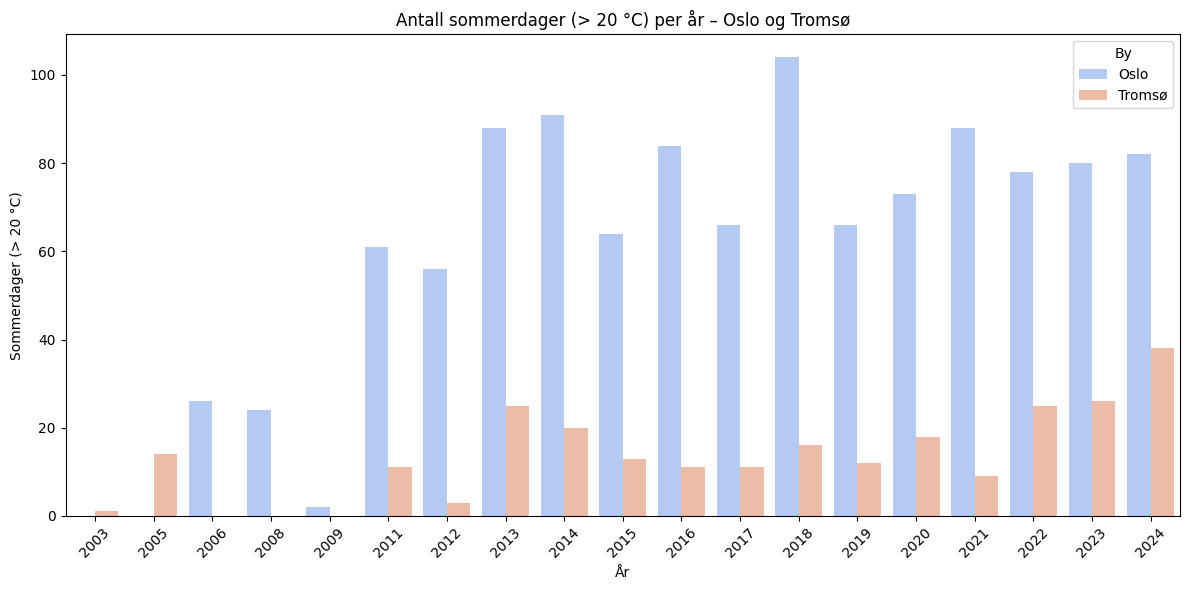

In [11]:
def summer_days_per_year(
    city: str,
    city_name: str,
    *,
    threshold: float = 20.0,
) -> pd.DataFrame:
    """
    Beregn antall dager over en temperatur­tærskel for ett år per år.

    Parametre:
        city (str): Bykode, f.eks. "oslo".
        city_name (str): Navn som skal vises i resultat-DataFramen.
        threshold (float): Temperatur­tærskel i °C.

    Returnerer:
        pd.DataFrame: Kolonnene ['year', 'summer_days', 'city'].
    """
    element_id = "max(air_temperature P1D)"
    offset = loader._get_min_offset(city, element_id)

    df = (
        loader._load_city(city)
        .query("elementId == @element_id and timeOffset == @offset")
        .copy()
    )
    df["referenceTime"] = pd.to_datetime(df["referenceTime"], utc=True)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    df["year"] = df["referenceTime"].dt.year
    mask = df["value"] > threshold
    out = (
        df.loc[mask]
        .groupby("year")
        .size()
        .reset_index(name="summer_days")
    )
    out["city"] = city_name
    return out


summer_days_df = pd.concat(
    [
        summer_days_per_year("oslo", "Oslo"),
        summer_days_per_year("tromso", "Tromsø"),
    ],
    ignore_index=True,
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=summer_days_df,
    x="year",
    y="summer_days",
    hue="city",
    palette="coolwarm",
)
plt.title("Antall sommerdager (> 20 °C) per år – Oslo og Tromsø")
plt.xlabel("År")
plt.ylabel("Sommerdager (> 20 °C)")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()

## Interaktiv versjon for visning av antall ekstrem verdier

In [12]:
cities = ["oslo", "tromso"]
element_ids = [
    "mean(air_temperature P1D)",
    "mean(wind_speed P1D)",
    "max(air_temperature P1D)",
    "min(air_temperature P1D)",
    "range(air_temperature P1D)",
    "sum(precipitation_amount P1D)",
]

app = Dash(__name__)
app.title = "Outlier-visualisering"

app.layout = html.Div(
    style={"maxWidth": "900px", "margin": "auto"},
    children=[
        html.H1("Ekstremverdier (Outliers) per måned"),
        html.Label("By:"),
        dcc.Dropdown(
            id="city-dropdown",
            options=[{"label": c.capitalize(), "value": c} for c in cities],
            value=cities[0],
            clearable=False,
        ),
        html.Label("Måletype (elementId):"),
        dcc.Dropdown(
            id="element-dropdown",
            options=[{"label": e, "value": e} for e in element_ids],
            value="sum(precipitation_amount P1D)",
            clearable=False,
        ),
        html.Label("Vis måneder uten outliers:"),
        dcc.Checklist(
            id="toggle-empty-months",
            options=[{"label": "Ja", "value": "vis"}],
            value=["vis"],
            inline=True,
        ),
        dcc.Graph(id="outlier-graph"),
    ],
)

@app.callback(
    Output("outlier-graph", "figure"),
    Input("city-dropdown", "value"),
    Input("element-dropdown", "value"),
    Input("toggle-empty-months", "value"),
)
def update_outlier_graph(city: str, element_id: str, show_empty_months: list[str]) -> go.Figure:
    """
    Oppdater grafen når brukeren endrer by, måletype eller visning.
    """
    include_empty = "vis" in show_empty_months
    offset = loader._get_min_offset(city, element_id)

    df_outliers = oa.find_outliers_per_month(
        city=city,
        element_id=element_id,
        time_offset=offset,
        include_empty_months=include_empty,
    )

    df_outliers["year_month"] = pd.to_datetime(df_outliers["year_month"])
    df_outliers["måned"] = df_outliers["year_month"].dt.strftime("%b %Y")

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_outliers["måned"],
            y=df_outliers["outliers_removed"],
            name="Antall outliers",
            mode="lines+markers",
            marker=dict(size=6),
            line=dict(color="firebrick"),
        )
    )

    fig.update_layout(
        title=(
            f"Antall outliers per måned – {element_id} "
            f"i {city.capitalize()} (Offset {offset})"
        ),
        xaxis=dict(title="Måned", tickangle=45),
        yaxis=dict(title="Antall outliers"),
        template="plotly_white",
    )
    return fig


if __name__ == "__main__":
    app.run(debug=True, port=8054)
